# Experimental regularization loss
*Use L(1 or 2) loss of the label loss derivative as a regularization loss.*  

## Setup

### Imports

In [1]:
from typing import Iterator

import torch
from torch import nn
from torch import Tensor
import plotly.express as px
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torchvision.datasets import MNIST
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize,
    RandomCrop,
)
from torchvision.utils import make_grid


from trainer import Trainer
from adversarial_attacks import ProjectedGradientDescent as PGD
from data_loaders import MyDataLoader

### Model definition

In [2]:
# Model from pytorch example: https://github.com/pytorch/examples/blob/main/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.gelu(x)
        x = self.conv2(x)
        x = F.gelu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net().cuda()

### Search for an accelerator

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Datasets, transforms and data loaders

In [4]:
! mkdir -p datasets

#### Transforms

In [5]:
CHANNELS_MEAN = (0.1307, )
CHANNELS_STD = (0.3081, )

training_transform = Compose([
    # RandomCrop(28, padding=6, padding_mode="constant"),
    ToTensor(),
    Normalize(CHANNELS_MEAN, CHANNELS_STD, inplace=True),
])

validation_transform = Compose([ToTensor(), Normalize(CHANNELS_MEAN, CHANNELS_STD)])

#### Datasets

In [6]:
training_dataset = MNIST(root="./datasets/mnist/", train=True, download=True, transform=training_transform)
validation_dataset = MNIST(root="./datasets/mnist/", train=False, transform=validation_transform)

#### Data loaders

In [7]:
BATCH_SIZE = 128

attacker = PGD(50, 30/255, CrossEntropyLoss(), model, 100/255)

training_dl = MyDataLoader(training_dataset, BATCH_SIZE, shuffle=True, num_workers=3, device=device, pin_memory=True)
test_dl = MyDataLoader(validation_dataset, BATCH_SIZE * 2, num_workers=3, device=device, pin_memory=True, attacker=attacker)

#### Dataset visualization

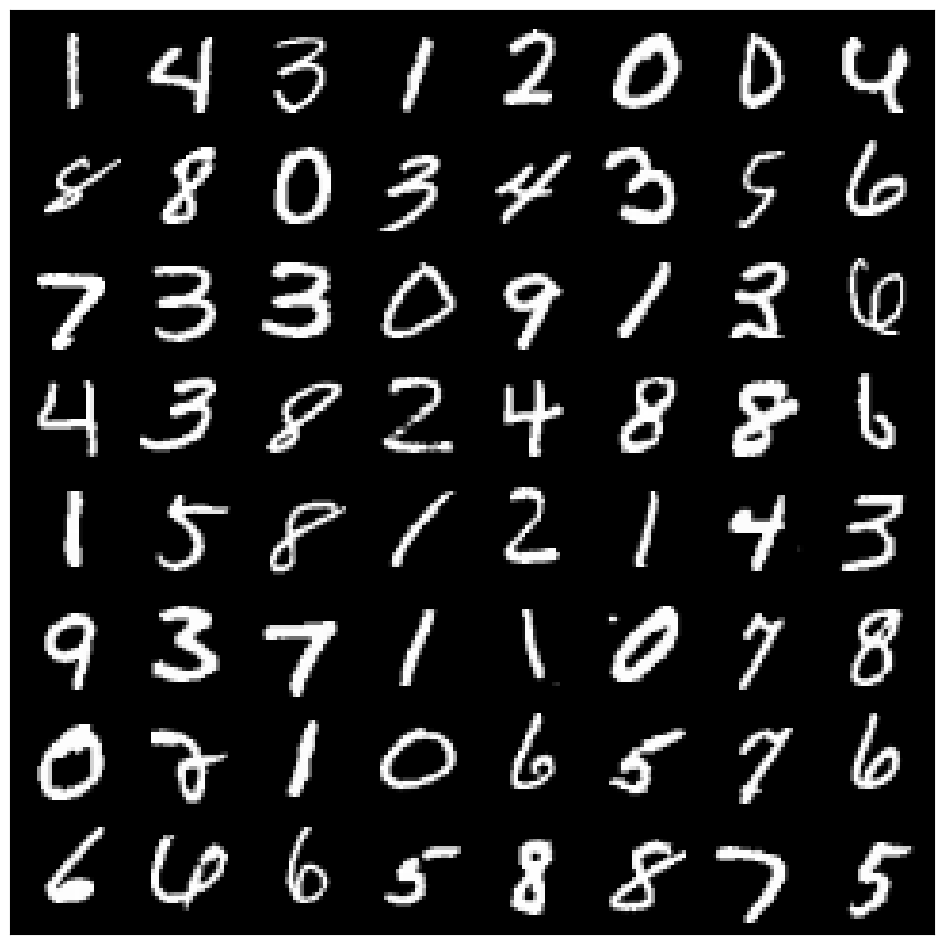

In [8]:
base_imgs, labels = next(iter(training_dl))
images, labels = base_imgs.cpu(), labels.cpu()
as_tensor = lambda stats: Tensor(stats).view(1, 1, 1, 1)
unormalize_imgs =  lambda imgs: imgs * as_tensor(CHANNELS_STD) + as_tensor(CHANNELS_MEAN)
images = unormalize_imgs(images)
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))

## Loss definition

In [9]:
class LGradientLoss(Adam):
    def __init__(self, params: Iterator[nn.Parameter], loss_gradient_loss: float, *args, **kwargs):
        # self.params = params
        self.loss_gradient_loss = loss_gradient_loss
        super().__init__(params, *args, **kwargs)
        # self.state = dict()
        # for group in self.param_groups:
        #     for p in group['params']:
        #         self.state[p] = dict(mom=torch.zeros_like(p.data))

    # Step Method
    def step(self):
        super().step()
        # for i, group in enumerate(self.param_groups):
        #     print(i, group.keys())
        #     print(i, group["params"])
        #     for param in group["params"]:
        #         param.grad = param.grad.add()
        # print("============================")

## Training

In [10]:
EPOCHS = 5
MAX_LR = 0.002
optimizer = LGradientLoss(model.parameters(), 0, MAX_LR, weight_decay=1e-4)

trainer = Trainer(
    model,
    optimizer,
    loss=CrossEntropyLoss(),
)

In [11]:
training_metrics = trainer.optimize_nn(
    epochs=EPOCHS,
    train_dl=training_dl,
    test_dl=test_dl,
    plt_kwargs=dict(x="epoch", y=["train_loss", "train_accuracy", "test_loss", "test_accuracy", "lr"], height=600),
).set_index("epoch")

FigureWidget({
    'data': [{'hovertemplate': 'variable=train_loss<br>epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'train_loss',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'train_loss',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'uid': '9c93de3b-4cc0-49a5-8221-36ffdd8e159e',
              'x': array([0]),
              'xaxis': 'x5',
              'y': array([2.30608278]),
              'yaxis': 'y5'},
             {'hovertemplate': 'variable=train_accuracy<br>epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'train_accuracy',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'train_accuracy',
              'orientation': 'v',
   

tensor(2.3174, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1., device='cuda:0')
torch.Size([])
tensor(2.0719, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1., device='cuda:0')
torch.Size([])
tensor(1.4638, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1., device='cuda:0')
torch.Size([])
tensor(1.1748, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1., device='cuda:0')
torch.Size([])
tensor(1.2232, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1., device='cuda:0')
torch.Size([])
tensor(0.8249, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1., device='cuda:0')
torch.Size([])
tensor(1.1045, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1., device='cuda:0')
torch.Size([])
tensor(0.8307, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1., device='cuda:0')
torch.Size([])
tensor(0.5968, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1., device='cuda:0')
torch.Size([])
tensor(0.6690, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1., de

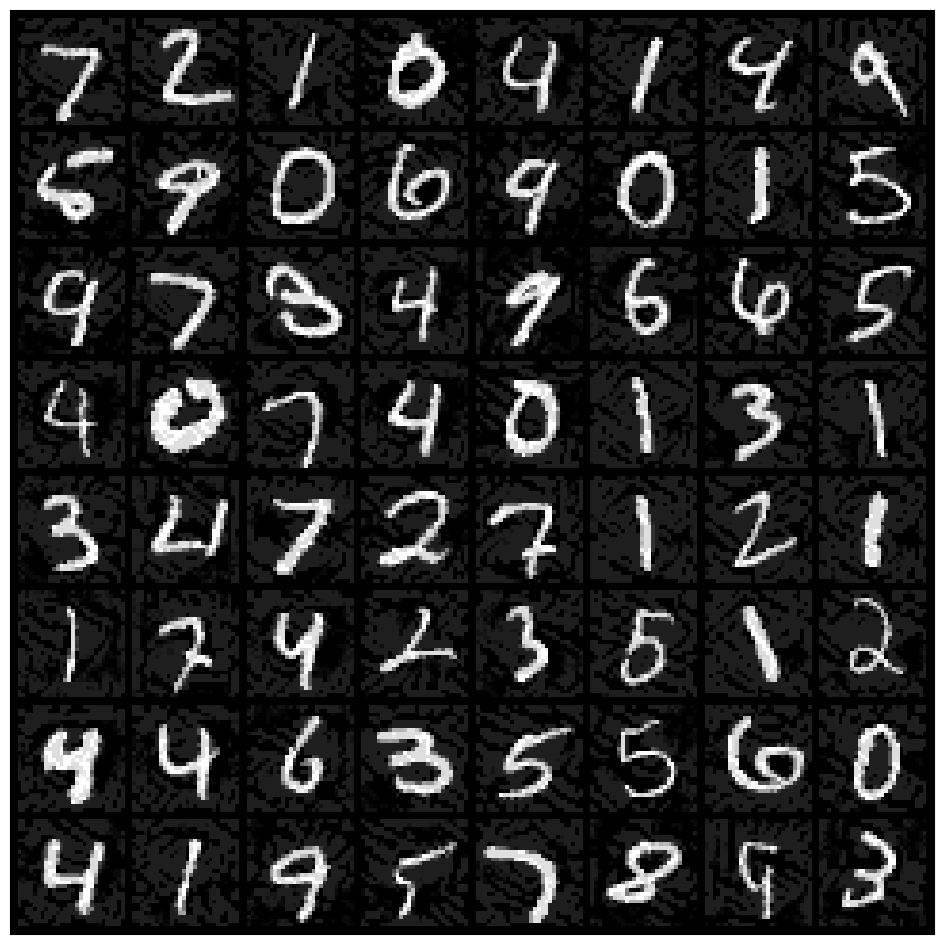

In [ ]:
base_imgs, labels = next(iter(test_dl))
images, labels = base_imgs.cpu(), labels.cpu()
as_tensor = lambda stats: Tensor(stats).view(1, 1, 1, 1)
unormalize_imgs =  lambda imgs: imgs * as_tensor(CHANNELS_STD) + as_tensor(CHANNELS_MEAN)
images = unormalize_imgs(images)
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images[BATCH_SIZE * 2:BATCH_SIZE * 2 + 64], nrow=8).permute(1, 2, 0))